In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer
from sklearn.utils import class_weight
from _functions import plot_confusion_matrix, custom_classification_report

In [3]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)
# df.head()
# df.isnull().sum()

In [4]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
X_cat_cols = ['country_state']

# location, description, requirements, country will be dropped.
y_col = ['fraudulent']

df2 = df[X_numeric_cols+X_text_cols+X_cat_cols+y_col].dropna()

X = df2[X_numeric_cols+X_text_cols+X_cat_cols]
y = df2[y_col]

In [5]:
##################################
##### Define hyperparameters #####
##################################

param_grid_xg = {
    'clf__n_estimators': [100, 150],
    'clf__max_depth': [3, 5, 10],
    'clf__learning_rate': [0.1, 0.01],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0]
}

In [6]:
###########################
##### Train the model #####
###########################
fbeta = make_scorer(fbeta_score, beta=2)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit TfidfVectorizer
preprocessor = ColumnTransformer(
    transformers=[
        ("title_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "title"),
        ("dnr_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "description_and_requirements"),
        ("num_scaled", MinMaxScaler(), X_numeric_cols),
        ("cat_encoded", OneHotEncoder(handle_unknown='ignore', sparse_output=True), X_cat_cols)
    ],
    remainder='drop'
)

# Train logistic regression model
model = Pipeline([
    ("preprocess", preprocessor),
    ("clf", XGBClassifier(random_state=42))
])

# compute class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.values.ravel())
class_weights = dict(enumerate(weights))

# set parameters for estimator
model.set_params(clf__class_weight=class_weights)
model.set_params(clf__class_weight=class_weights)

k = 5
kF = KFold(n_splits=k, shuffle=True, random_state=42)

xgboost_grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid_xg,
    scoring=fbeta,
    cv=kF,
    n_jobs=-1,
    verbose=1
)

xgboost_grid.fit(X_train, y_train)
best_xgboost_model = xgboost_grid.best_estimator_
# Make predictions and print classification report
y_pred = best_xgboost_model.predict(X_test)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/miniconda3/envs/ml/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:21:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/ml/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:21:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/ml/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:21:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/miniconda3/envs/ml/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [15:21:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "class_weight" } are not used.

  bst.update(dtr

Best parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 150, 'clf__subsample': 1.0}
Classification Report:
           precision    recall  f1-score  f2-score   support

Not Fraud       0.99      1.00      0.99      1.00      3361
    Fraud       0.98      0.82      0.89      0.84       246

 accuracy                                     0.99      3607

F2 Score: 0.8445378151260504


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'XGBoost Confusion Matrix, k=5'}, xlabel='Predicted label', ylabel='True label'>)

<Figure size 600x500 with 0 Axes>

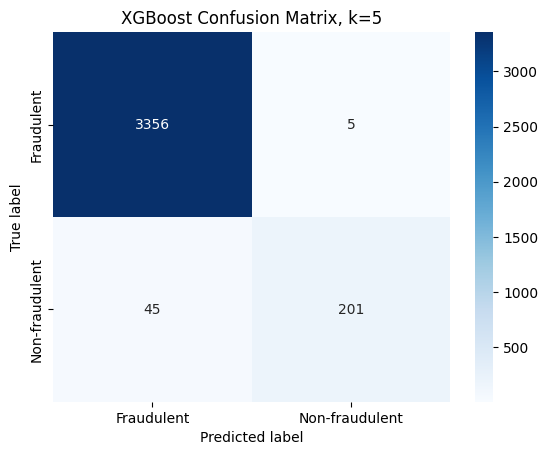

In [10]:
###########################
##### Display results #####
###########################

print("Best parameters:", xgboost_grid.best_params_)
print("Classification Report:")
print(custom_classification_report(y_test, y_pred))
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2, average='binary'))
plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=[0, 1]), f"XGBoost Confusion Matrix, k=5")

In [8]:
##########################
##### Save the model #####
##########################

import pickle

# Save the model
filename = f'models/xgboost_model_k={k}.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_xgboost_model, file)